In [1]:
import random
import dimod
import networkx as nx
import numpy as np
from dwave.system import LeapHybridSampler
from dwave.samplers import TabuSampler
from itertools import product
import scipy.optimize as opt

from utils import distance, output_image

import matplotlib

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

In [2]:
def set_up_scenario(w, h, num_poi, num_cs):
    """Build scenario set up with specified parameters.

    Args:
        w (int): Width of grid
        h (int): Height of grid
        num_poi (int): Number of points of interest
        num_cs (int): Number of existing charging stations

    Returns:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints):
            Set of current charging locations
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
    """

    G = nx.grid_2d_graph(w, h)
    nodes = list(G.nodes)

    # Identify a fixed set of points of interest
    pois = random.sample(nodes, k=num_poi)

    # Identify a fixed set of current charging locations
    charging_stations = random.sample(nodes, k=num_cs)

    # Identify potential new charging locations
    potential_new_cs_nodes = list(G.nodes() - charging_stations)

    return G, pois, charging_stations, potential_new_cs_nodes

In [4]:
def build_bqm(
    potential_new_cs_nodes,
    num_poi,
    pois,
    num_cs,
    charging_stations,
    num_new_cs,
    hyperparams=np.array([4, 3, 1.7, 10]),
):
    """Build bqm that models our problem scenario for the hybrid sampler.

    Args:
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
        num_poi (int): Number of points of interest
        pois (list of tuples of ints): A fixed set of points of interest
        num_cs (int): Number of existing charging stations
        charging_stations (list of tuples of ints):
            Set of current charging locations
        num_new_cs (int): Number of new charging stations desired

    Returns:
        bqm_np (BinaryQuadraticModel): QUBO model for the input scenario
    """
    a, b, c, d = hyperparams

    # Tunable parameters
    gamma1 = len(potential_new_cs_nodes) * a  # 4
    gamma2 = len(potential_new_cs_nodes) / b  # 3
    gamma3 = len(potential_new_cs_nodes) * c  # 1.7
    gamma4 = len(potential_new_cs_nodes) ** d  # 3

    # Build BQM using adjVectors to find best new charging location s.t. min
    # distance to POIs and max distance to existing charging locations
    bqm = dimod.BinaryQuadraticModel(len(potential_new_cs_nodes), "BINARY")

    # Constraint 1: Min average distance to POIs
    if num_poi > 0:
        for i in range(len(potential_new_cs_nodes)):
            # Compute average distance to POIs from this node
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = sum(distance(cand_loc, loc) for loc in pois) / num_poi
            bqm.linear[i] += avg_dist * gamma1

    # Constraint 2: Max distance to existing chargers
    if num_cs > 0:
        for i in range(len(potential_new_cs_nodes)):
            # Compute average distance to POIs from this node
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = (
                sum(distance(cand_loc, loc) for loc in charging_stations) / num_cs
            )
            bqm.linear[i] -= avg_dist * gamma2

    # Constraint 3: Max distance to other new charging locations
    if num_new_cs > 1:
        for i in range(len(potential_new_cs_nodes)):
            for j in range(i + 1, len(potential_new_cs_nodes)):
                ai = potential_new_cs_nodes[i]
                aj = potential_new_cs_nodes[j]
                dist = -distance(ai, aj)
                bqm.add_interaction(i, j, dist * gamma3)

    # Constraint 4: Choose exactly num_new_cs new charging locations
    bqm.update(
        dimod.generators.combinations(bqm.variables, num_new_cs, strength=gamma4)
    )

    return bqm

In [5]:
def run_bqm_and_collect_solutions(
    bqm, sampler, potential_new_cs_nodes, n_shots=1, **kwargs
):
    """Solve the bqm with the provided sampler to find new charger locations.

    Args:
        bqm (BinaryQuadraticModel): The QUBO model for the problem instance
        sampler: Sampler or solver to be used
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
        **kwargs: Sampler-specific parameters to be used

    Returns:
        new_charging_nodes (list of tuples of ints):
            Locations of new charging stations
    """

    sampleset = sampler.sample(
        bqm, num_reads=n_shots, label="Example - EV Charger Placement", **kwargs
    )
    ss = sampleset.first.sample
    new_charging_nodes = [potential_new_cs_nodes[k] for k, v in ss.items() if v == 1]
    return sampleset, new_charging_nodes

In [65]:
def score_sampleset(sampleset, potential_new_cs_nodes, pois, charging_stations, new_charging_nodes=None):
    """
    Score the sampleset based on the distance to POIs and existing charging stations.
    """
    n_samples = len(sampleset)

    if new_charging_nodes is None:
        new_charging_nodes = [
            [potential_new_cs_nodes[k] for k, v in sample.items() if v == 1]
            for sample in sampleset
        ]

    min_dist = np.zeros((len(new_charging_nodes), len(pois)))
    for i, new_cs in enumerate(new_charging_nodes):
        for j, p in enumerate(pois):
            min_dist[i][j] = min(distance(p, c) for c in new_cs + charging_stations)

    min_dist = min_dist.sum(axis=1)
    score = min_dist.mean() + min_dist.var()
    return score

In [7]:
def hypersearch(
    potential_new_cs_nodes,
    num_poi,
    pois,
    num_cs,
    charging_stations,
    num_new_cs,
    init_guess=np.array([4, 3, 1.7, 10]),
):
    """
    Perform hyperparameter search to find the best hyperparameters for the problem.
    """
    #init_guess += [100, 100, 100, 0]

    def objective(hyperparams):
        bqm = build_bqm(
            potential_new_cs_nodes,
            num_poi,
            pois,
            num_cs,
            charging_stations,
            num_new_cs,
            hyperparams=hyperparams,
        )
        sampleset, _ = run_bqm_and_collect_solutions(bqm, TabuSampler(), potential_new_cs_nodes, n_shots=10)
        score = score_sampleset(sampleset, potential_new_cs_nodes, pois, charging_stations)
        return score

    result = opt.minimize(objective, init_guess, method="Nelder-Mead", options={"disp": True})
    
    final_params = result.x
    #final_params -= [100, 100, 100, 0]

    return final_params

In [9]:
WIDTH = 15
HEIGHT = 20
POI = 5
CHARGERS = 3
NEW_CHARGERS = 3

WIDTH = 30
HEIGHT = 30
POI = 10
CHARGERS = 3
NEW_CHARGERS = 3

G, pois, charging_stations, potential_new_cs_nodes = set_up_scenario(
    WIDTH, HEIGHT, POI, CHARGERS
)

hyperparams = np.array([4, 3, 1.7, 3])

In [10]:
hyperparams = hypersearch(potential_new_cs_nodes, POI, pois, CHARGERS, charging_stations, NEW_CHARGERS)
hyperparams

C:\Users\Félix Moras\AppData\Local\Temp\ipykernel_18748\2258120689.py:29: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = opt.minimize(objective, init_guess, method="Nelder-Mead", options={"disp": True})


array([ 3.95263233,  3.06211524,  1.76156091, 10.11568117])


Score:  55634.16560000001


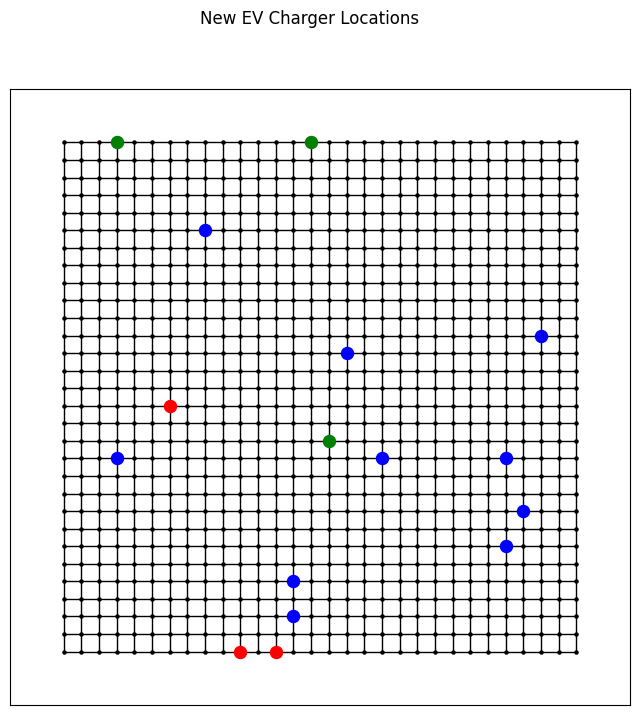

In [66]:
# Build BQM
bqm = build_bqm(
    potential_new_cs_nodes,
    POI,
    pois,
    CHARGERS,
    charging_stations,
    NEW_CHARGERS,
    hyperparams,
)

# Run BQM on HSS
sampler = TabuSampler()
# print("\nRunning scenario on", sampler.solver.id, "solver...")

sampleset, new_charging_nodes = run_bqm_and_collect_solutions(
    bqm, sampler, potential_new_cs_nodes, n_shots=100
)

# Calculate score
score = score_sampleset(sampleset, potential_new_cs_nodes, pois, charging_stations)

# Create scenario output image
print("\nScore: ", score)
output_image(G, pois, charging_stations, new_charging_nodes)